In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from vae_architecture import EEGNetVAELayers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.contrib.slim.nets import resnet_v2

print(tf.__version__)
import tensorflow.random

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import imageio
import eeg_data
import math
from sklearn.decomposition import PCA

from IPython import display

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

1.12.0


In [2]:
def resnet_12(inputs, num_classes, scope='resnet_12'):
    blocks = [resnet_v2.resnet_v2_block('block1', base_depth=64, num_units=2, stride=1),
              resnet_v2.resnet_v2_block('block2', base_depth=64, num_units=2, stride=1),
              resnet_v2.resnet_v2_block('block3', base_depth=64, num_units=2, stride=1),
              resnet_v2.resnet_v2_block('block4', base_depth=64, num_units=2, stride=1),
              resnet_v2.resnet_v2_block('block5', base_depth=64, num_units=2, stride=1)]
    return resnet_v2.resnet_v2(inputs, blocks, num_classes, is_training=True,
                   global_pool=True, output_stride=None,
                   include_root_block=True,
                   reuse=None, scope=scope)


In [3]:
import eeg_data

n_channel = 19
n_sample = 128


def get_overlap(data, percent_overlap, seq_len=128):
    stride_size = seq_len - int(percent_overlap * seq_len)
    num_seq = int((len(data) - seq_len) / stride_size) + 1
    for i in range(num_seq):
        yield np.moveaxis(data[i*stride_size:i*stride_size+seq_len], 0, 1)
        
def get_overlap_indices(indices, percent_overlap, seq_len=128):
    stride_size = seq_len - int(percent_overlap * seq_len)
    num_seq = int((len(indices) - seq_len) / stride_size) + 1
    for i in range(num_seq):
        yield indices[i*stride_size]

def load_data(percent_overlap=0.9):
    train_total_raw, train_total_data, train_overlap_data, train_indices, \
    test_raw, test_data, test_overlap_data, test_indices, \
    _, _, _, segment_indices = eeg_data.get_eeg_data()

    #train_total_data = np.reshape(train_overlap_data,
    #            (train_overlap_data.shape[0], train_overlap_data.shape[1], train_overlap_data.shape[2], 1)).astype(np.float32)
    #test_data = np.reshape(test_overlap_data, 
    #            (test_overlap_data.shape[0], test_overlap_data.shape[1], test_overlap_data.shape[2], 1)).astype(np.float32)

    train_data = np.moveaxis(train_total_raw, -1, 1).reshape((-1,19))
    test_data = np.moveaxis(test_raw, -1, 1).reshape((-1,19))

    train_total_data = np.expand_dims(list(get_overlap(train_data, percent_overlap)), -1).astype(np.float32)
    train_indices = np.array(list(get_overlap_indices(train_indices, percent_overlap)), dtype=np.int32)

    test_data = np.expand_dims(list(get_overlap(test_data, percent_overlap)), -1).astype(np.float32)
    test_indices = np.array(list(get_overlap_indices(test_indices, percent_overlap)), dtype=np.int32)

    # normalize data
    train_total_data -= train_total_data.min()
    train_total_data /= train_total_data.max()
    test_data -= test_data.min()
    test_data /= test_data.max()

    train_total_data = train_total_data[:,list(range(n_channel)),:,:]
    test_data = test_data[:,list(range(n_channel)),:,:]

    #train_total_data = train_total_data.reshape((-1,1,n_sample,1))
    #test_data = test_data.reshape((-1,1,n_sample,1))
    
    return train_total_data, test_data, train_indices, test_indices

train_total_data, test_data, train_indices, test_indices = load_data()


In [4]:
TRAIN_BUF = 60000
BATCH_SIZE = 1000

class GraphDataset:
    def __init__(self, data):
        self.data = data
    
    def from_data(data):
        d = data.copy()
        ds = GraphDataset(d)
        return ds
    
    def shuffle(self, buff=0):
        np.random.shuffle(self.data)
        return self
        
    def batch(self, size):
        self.batch_size = size
        return self
        
    def batches(self):
        total_batches = np.int64(np.ceil(self.data.shape[0] / self.batch_size))
        for i in range(total_batches):
            start = i*self.batch_size
            end = min((i+1)*self.batch_size, self.data.shape[0])
            yield self.data[start:end]

TEST_BUF = 10000
train_dataset = GraphDataset.from_data(train_total_data).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = GraphDataset.from_data(test_data).shuffle(TEST_BUF).batch(BATCH_SIZE)




In [5]:
tensorboard_logdir = "/cache/tensorboard-logdir/vanilla_vae"
global_step = 0
writer = tf.contrib.summary.create_file_writer(tensorboard_logdir)


In [6]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, input_dim, hidden_dim, architecture="mlp", loss_type='vanilla', beta=1.0):
        self.scope = '{}_{}_{}_{}'.format(loss_type, architecture, hidden_dim, latent_dim)
        global n_channel, n_sample
        with tf.name_scope(self.scope):
            super(CVAE, self).__init__()

            self.session = tf.Session()

            self.beta = beta
            self.loss_type = loss_type
            self.latent_dim = latent_dim
            self.hidden_dim = hidden_dim
            pad_amt = 12 - (latent_dim % 12) 
            channel_dim = int(np.ceil(latent_dim / 12))

            conv_shape = (5,1,hidden_dim)

            if architecture == 'mlp':
                self.architecture = '2-layer MLP'
                input_shape = (n_channel,n_sample,1)
                self.inference_net = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape=input_shape),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                    tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                    tf.keras.layers.Dense(latent_dim*3, name='z_out')   
                ])

                self.generative_net = tf.keras.Sequential([
                    tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                    tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                    tf.keras.layers.Dense(input_dim)
                ])
            elif architecture == 'conv1d':
                self.architecture = '1D Convolution'
                input_shape = (n_channel,n_sample,1)
                self.inference_net = tf.keras.Sequential([
                    tf.keras.layers.Reshape((input_shape[0], input_shape[1])),
                    tf.keras.layers.Permute((2,1)),
                    tf.keras.layers.Conv1D(hidden_dim, kernel_size=8, strides=4, activation=tf.nn.relu),
                    tf.keras.layers.Conv1D(hidden_dim, kernel_size=8, strides=4, activation=tf.nn.relu, padding='same'),
                    tf.keras.layers.Conv1D(hidden_dim, kernel_size=3, activation=tf.nn.relu),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(latent_dim*3, name='z_out')
                ])
                self.generative_net = tf.keras.Sequential([
                    tf.keras.layers.Dense(5*hidden_dim, input_shape=(latent_dim,)),
                    tf.keras.layers.Reshape(conv_shape),
                    tf.keras.layers.Conv2DTranspose(hidden_dim, kernel_size=(3,1), activation=tf.nn.relu),
                    tf.keras.layers.Conv2DTranspose(hidden_dim, kernel_size=(8,1), strides=(4,1), activation=tf.nn.relu),
                    tf.keras.layers.Conv2DTranspose(hidden_dim, kernel_size=(8,1), strides=(4,1), activation=tf.nn.relu),
                    tf.keras.layers.Conv2D(n_channel, kernel_size=(1,1), padding='same'),
                    tf.keras.layers.Lambda(lambda x: x[:,:n_sample]),
                    tf.keras.layers.Permute((3,1,2))
                ])    
            elif architecture == 'eegnet':
                self.architecture = 'EEGNet (2D Convolution)'
                filter_size=5
                pool_size=2
                input_shape = (n_channel,n_sample,1)
                conv_shape=(5,1,hidden_dim*8)
                self.inference_net = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(hidden_dim, kernel_size=(1,filter_size), activation=None),
                    tf.keras.layers.Conv2D(hidden_dim, kernel_size=(n_channel,1), activation=tf.nn.elu),
                    tf.keras.layers.Reshape((-1,hidden_dim,1)),
                    tf.keras.layers.MaxPool2D((pool_size,1), strides=(pool_size,1)),
                    tf.keras.layers.Conv2D(hidden_dim*2, kernel_size=(filter_size,hidden_dim), activation=tf.nn.elu),
                    tf.keras.layers.Reshape((-1,hidden_dim*2,1)),
                    tf.keras.layers.MaxPool2D((pool_size,1), strides=(pool_size,1)),
                    tf.keras.layers.Conv2D(hidden_dim*4, kernel_size=(filter_size,hidden_dim*2), activation=tf.nn.elu),
                    tf.keras.layers.Reshape((-1,hidden_dim*4,1)),
                    tf.keras.layers.MaxPool2D((pool_size,1), strides=(pool_size,1)), 
                    tf.keras.layers.Conv2D(hidden_dim*8, kernel_size=(filter_size,hidden_dim*4), activation=tf.nn.elu),
                    tf.keras.layers.Reshape((-1,hidden_dim*8,1)),
                    tf.keras.layers.MaxPool2D((pool_size,1), strides=(pool_size,1)),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(latent_dim*3, name='z_out') 
                ])
                self.generative_net = tf.keras.Sequential([
                    tf.keras.layers.Dense(np.prod(list(conv_shape))),
                    tf.keras.layers.Reshape(conv_shape),
                    tf.keras.layers.UpSampling2D(size=(pool_size,1)),
                    tf.keras.layers.Lambda(lambda x: x[:,:9]),
                    tf.keras.layers.Conv2DTranspose(hidden_dim*8,kernel_size=(filter_size,1),activation=tf.nn.elu),
                    tf.keras.layers.UpSampling2D(size=(pool_size,1)),
                    tf.keras.layers.Lambda(lambda x: x[:,:25]),
                    tf.keras.layers.Conv2DTranspose(hidden_dim*4,kernel_size=(filter_size,1),activation=tf.nn.elu),
                    tf.keras.layers.UpSampling2D(size=(pool_size,1)),
                    tf.keras.layers.Lambda(lambda x: x[:,:58]),
                    tf.keras.layers.Conv2DTranspose(hidden_dim*2,kernel_size=(filter_size,1),activation=tf.nn.elu),       
                    tf.keras.layers.UpSampling2D(size=(pool_size,1)),
                    tf.keras.layers.Lambda(lambda x: x[:,:124]),
                    tf.keras.layers.Reshape((1,-1,hidden_dim*2)),
                    tf.keras.layers.Conv2DTranspose(hidden_dim, kernel_size=(n_channel,1), activation=tf.nn.elu),
                    tf.keras.layers.Conv2DTranspose(hidden_dim, kernel_size=(1,filter_size), activation=tf.nn.elu),
                    tf.keras.layers.Conv2D(1,kernel_size=(1,1),activation=None)
                ])
            self.inputs = tf.placeholder(shape=[None] + list(input_shape), dtype=tf.float32)

            self.loss = self.compute_loss()
            self.train_op = tf.train.AdamOptimizer(1e-4).minimize(self.loss)

            self.session.run(tf.global_variables_initializer())
        
        
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

    def reconstruct(self, x):    
        return self.session.run(self.outputs, feed_dict={self.inputs: x})

    def encode(self):
        mean, logvar, iaf_h = tf.split(self.inference_net(self.inputs), num_or_size_splits=3, axis=1)
        return mean, logvar, iaf_h

    def latent_code(self, x):
        z = self.session.run(self.z, feed_dict={self.inputs: x})
        if self.loss_type == 'mmd':
            z *= self.beta
        return z

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.generative_net(z)
        self.outputs = tf.sigmoid(logits)
        return logits

    def iaf(self, mean, logvar, h, n_transforms=2): 
        eps = tf.random.normal(tf.shape(mean))
        z = eps * tf.exp(logvar * .5) + mean
        
        logq_zx = -tf.reduce_sum(0.5 * logvar + 0.5 * tf.square(eps) + 0.5 * np.log(2*np.pi), axis=1)

        base_dist = tfd.MultivariateNormalDiag(tf.zeros_like(mean))

        for i in range(n_transforms):
            
            z = tf.reverse(z, axis=[1])
            inp = tf.layers.dense(tf.concat((z,h), axis=1), self.latent_dim, activation=tf.nn.relu)
            
            
            autoregressive_network = tfp.bijectors.masked_autoregressive_default_template(hidden_layers=[512,512])
            mu, sigma = autoregressive_network(inp)
            sigma = tf.nn.sigmoid(sigma)            
            
            z = sigma * z + (1 - sigma) * mu
            
            logq_zx -= tf.reduce_sum(tf.log(sigma), axis=1)

        logp_z = base_dist.log_prob(z)
        return  logq_zx - logp_z, z

    def compute_loss(self, which_set='train'):
        mean, logvar, iaf_h = self.encode()
        if self.loss_type == 'mmd':
            self.z = mean
            true_samples = tf.random.normal(shape=tf.shape(mean))
            posterior_loss = compute_mmd(true_samples, self.z)
        elif self.loss_type == 'iaf':
            posterior_loss, self.z = self.iaf(mean, logvar, iaf_h)
        else:
            self.z = self.reparameterize(mean, logvar)

            logpz = log_normal_pdf(self.z, tf.zeros_like(mean), tf.zeros_like(logvar)) 
            logqz_x = log_normal_pdf(self.z, mean, logvar)
            posterior_loss = logqz_x - logpz
        
        self.posterior_loss = tf.reduce_mean(posterior_loss)


        x_logit = tf.reshape(self.decode(self.z), tf.shape(self.inputs))
        
        self.recon_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=self.inputs))
        total_loss = self.recon_loss + self.beta * self.posterior_loss

        return total_loss



class CVAE1D(CVAE):
    def __init(self, latent_dim, input_dim, hidden_dim, kernel_size=3):
        
        self.latent_dim = latent_dim
        super(CVAE1D, self).__init__(latent_dim, input_dim, hidden_dim, architecture='mlp')
        
        if architecture == 'mlp':
            self.inference_net = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
                tf.keras.layers.Dense(latent_dim*3)   
            ])
        else:
            self.inference_net = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Conv1D(hidden_dim, kernel_size=kernel_size, activation=tf.nn.relu),
                tf.keras.layers.MaxPool1D(pool_size=3),
                tf.keras.layers.Conv1D(hidden_dim, kernel_size=kernel_size, activation=tf.nn.relu),
                tf.keras.layers.MaxPool1D(pool_size=3),
                tf.keras.layers.Dense(latent_dim*3)   
            ])
        
        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(input_dim)
        ])


In [7]:
def plot_reconstruction_simple(input_sequence, reconstruction, latent_dim):
    plt.clf()
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
    x = list(range(len(input_sequence)))
    ax.plot(x, input_sequence)
    ax.plot(x, reconstruction)
    
    #ax.set_ylabel("Latent dim = {}".format(latent_dim))
    

def plot_reconstruction(input_sequence, reconstruction, subplot_dims):
    
    x = list(range(len(input_sequence)))
    ax = plt.subplot(3, 4, subplot_dims)
    ax.cla()
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
    ax.plot(x, input_sequence)
    ax.plot(x, reconstruction)
    
    x_idx = subplot_dims % 4
    if x_idx == 1:
        ax.set_ylabel("Latent dim = {}".format(latent_dims[int(subplot_dims/4)]))
    
    if subplot_dims > 8:
        ax.set_xlabel("Hidden dim = {}".format(hidden_dims[int(x_idx-1)]))
    
def display_reconstruction(subplot_dims, mmd_loss=False, iaf=False):
    sample = np.expand_dims(train_total_data[1], axis=0)
    reconstruction = model.reconstruct(sample)
    sample = sample.reshape((1,1,128,-1))
    reconstruction = reconstruction.reshape((1,1,128,-1))
    plot_reconstruction(sample[0,0,:,0], reconstruction[0,0,:,0], subplot_dims)
    
    
    
    

In [8]:
def log_normal_pdf(sample, mean, logvar):
    base_dist = tfd.MultivariateNormalDiag(loc=mean, scale_diag=tf.maximum(tf.exp(0.5*logvar), 1e-15))
    return base_dist.log_prob(sample)

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = tf.tile(tf.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = tf.sqrt(tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel))
    return mmd


def train(model, x):
    model.session.run([model.train_op], 
                      feed_dict={model.inputs: x})

def get_loss(model, x):
    return model.session.run([model.loss, 
                              model.posterior_loss, 
                              model.recon_loss], 
                             feed_dict={model.inputs: x})

In [9]:
def get_distance_measurements(model):
    test_dataset = GraphDataset.from_data(train_total_data).batch(BATCH_SIZE)
    latents = np.concatenate([model.latent_code(batch) for batch in test_dataset.batches()], axis=0) 
    seq_latents = np.array(latents)
    seq_dist = np.mean(np.sqrt(np.sum(np.square(np.diff(latents,axis=0)), axis=1)))
    n_random = 10
    rand_dist = 0
    for n in range(n_random):
        np.random.shuffle(latents)
        rand_dist += np.mean(np.sqrt(np.sum(np.square(np.diff(latents,axis=0)), axis=1)))
    return seq_dist, rand_dist / n_random

    
def calculate_distance(model):
    global segment_indices, test_data, train_total_data
    test_dataset = GraphDataset.from_data(test_data).batch(BATCH_SIZE)

    segment_indices = segment_indices.astype(np.int32)
    num_seqs = 1000
    n_random = 1000
    
    test_copy = train_total_data.copy()
    
    all_latents = np.concatenate([model.latent_code(batch) for batch in test_dataset.batches()], axis=0) 
    seq_latents = all_latents[:num_seqs].copy()
    
    dist = np.mean(np.sqrt(np.sum(np.square(np.diff(seq_latents,axis=0)), axis=1)))
    seq_dist = dist
    print("Mean sequence distance: {}".format(seq_dist))
    rand_len = 0
    shorter = 0
    for i in range(n_random):
        
        np.random.shuffle(all_latents)
        latents = all_latents[:num_seqs]
        dist = np.mean(np.sqrt(np.sum(np.square(np.diff(latents,axis=0)), axis=1)))
        rand_len += dist
        if seq_dist < dist:
            shorter += 1
            
    
    if latents.shape[1] > 2:
        pca = PCA(n_components=2)
        pca.fit(all_latents)
        latents = pca.transform(latents)
        seq_latents = pca.transform(seq_latents)

    #X_pca = pca.transform(np.concatenate((latents, seq_latents), axis=0))
    plt.scatter(latents[:,0], latents[:,1], color='tab:blue')
    plt.scatter(seq_latents[:100,0], seq_latents[:100,1], color='tab:orange')
    plt.show()
        
            
    print("Mean random distance: {}".format(rand_len / n_random))

    print("Non-random is shorter {}% of the time".format(100.0 * shorter / n_random))
    print("Non-random is {}% longer than random.".format(100.0 * (seq_dist - (rand_len / n_random)) / (rand_len / n_random)))
    return shorter / n_random

In [10]:
def show_example_reconstruction(model, idx=1):
    print(model.scope)
    sample = np.expand_dims(train_total_data[idx], axis=0)
    reconstruction = model.reconstruct(sample)
    sample = sample.reshape((1,1,n_sample,-1))
    reconstruction = reconstruction.reshape((1,1,n_sample,-1))
    plot_reconstruction_simple(sample[0,0,:,0], reconstruction[0,0,:,0], model.latent_dim)

    plt.show()

mmd_conv1d_500_64: total_parameters=8327211
vanilla_conv1d_500_64: total_parameters=8327211
Training model mmd_conv1d_500_64, epoch=1
Epoch: 1, Test set losses: [0.69132683 0.01672652 0.67460032], time elapsed for current epoch 40.13236618041992
mmd_conv1d_500_64


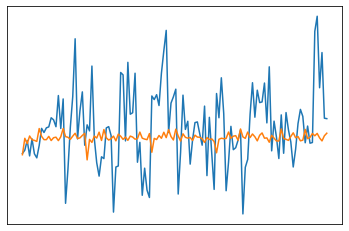

Training model vanilla_conv1d_500_64, epoch=1
Epoch: 1, Test set losses: [ 0.674466   25.37992774  0.6743391 ], time elapsed for current epoch 30.75743865966797
vanilla_conv1d_500_64


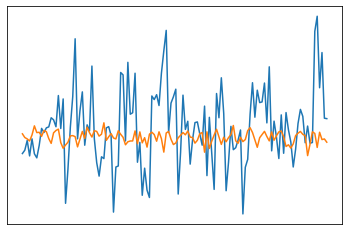

Training model mmd_conv1d_500_64, epoch=2
Epoch: 2, Test set losses: [0.69141753 0.0167795  0.67463803], time elapsed for current epoch 36.093358755111694
mmd_conv1d_500_64


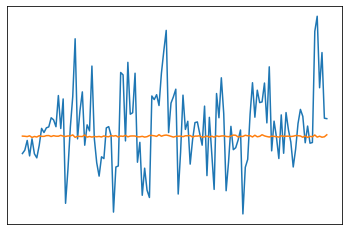

Training model vanilla_conv1d_500_64, epoch=2
Epoch: 2, Test set losses: [ 0.67440637 18.87999217  0.67431197], time elapsed for current epoch 30.1777606010437
vanilla_conv1d_500_64


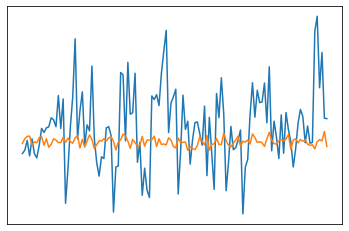

Training model mmd_conv1d_500_64, epoch=3
Epoch: 3, Test set losses: [0.69130233 0.01669634 0.67460599], time elapsed for current epoch 36.0963990688324
mmd_conv1d_500_64


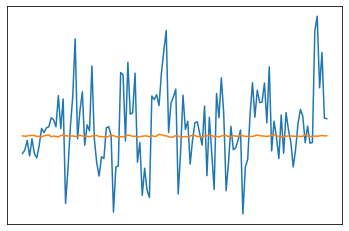

Training model vanilla_conv1d_500_64, epoch=3
Epoch: 3, Test set losses: [ 0.6743118  15.30076504  0.67423529], time elapsed for current epoch 29.673757553100586
vanilla_conv1d_500_64


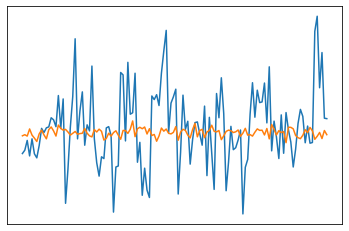

Training model mmd_conv1d_500_64, epoch=4
Epoch: 4, Test set losses: [0.69098482 0.01659665 0.67438817], time elapsed for current epoch 36.006659507751465
mmd_conv1d_500_64


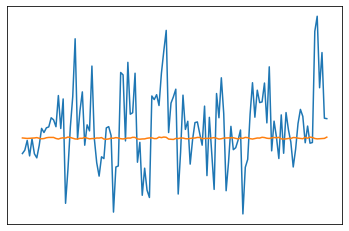

Training model vanilla_conv1d_500_64, epoch=4
Epoch: 4, Test set losses: [ 0.67413186 11.75218768  0.6740731 ], time elapsed for current epoch 29.834288835525513
vanilla_conv1d_500_64


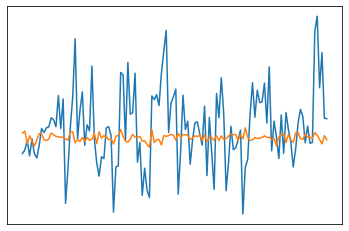

Training model mmd_conv1d_500_64, epoch=5
Epoch: 5, Test set losses: [0.69088944 0.01671326 0.67417617], time elapsed for current epoch 35.73756551742554
mmd_conv1d_500_64


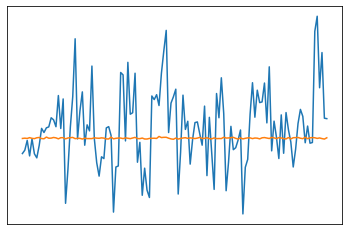

Training model vanilla_conv1d_500_64, epoch=5
Epoch: 5, Test set losses: [ 0.6741706  10.12535148  0.67411997], time elapsed for current epoch 29.416929483413696
vanilla_conv1d_500_64


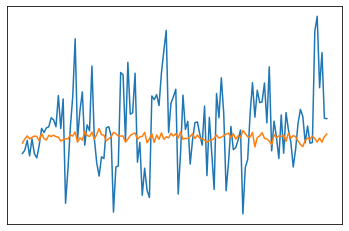

Training model mmd_conv1d_500_64, epoch=6
Epoch: 6, Test set losses: [0.69130802 0.01672609 0.67458193], time elapsed for current epoch 36.167489767074585
mmd_conv1d_500_64


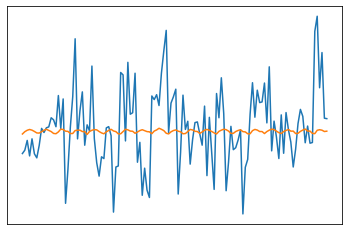

Training model vanilla_conv1d_500_64, epoch=6
Epoch: 6, Test set losses: [0.67418523 9.50497447 0.67413771], time elapsed for current epoch 29.42444157600403
vanilla_conv1d_500_64


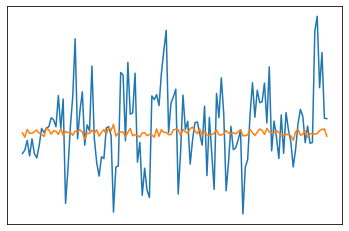

Training model mmd_conv1d_500_64, epoch=7
Epoch: 7, Test set losses: [0.69111401 0.01670905 0.67440496], time elapsed for current epoch 35.3472318649292
mmd_conv1d_500_64


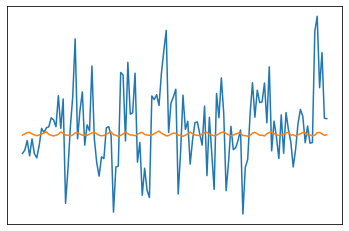

Training model vanilla_conv1d_500_64, epoch=7
Epoch: 7, Test set losses: [0.67382545 8.68636152 0.67378202], time elapsed for current epoch 30.154357194900513
vanilla_conv1d_500_64


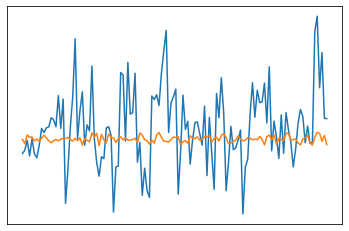

Training model mmd_conv1d_500_64, epoch=8
Epoch: 8, Test set losses: [0.69110918 0.01672502 0.67438415], time elapsed for current epoch 35.42274856567383
mmd_conv1d_500_64


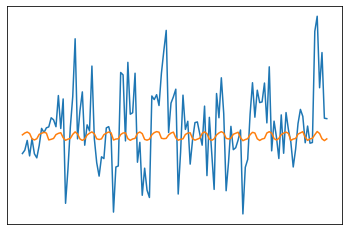

Training model vanilla_conv1d_500_64, epoch=8
Epoch: 8, Test set losses: [0.67403535 8.05679398 0.67399506], time elapsed for current epoch 29.407509088516235
vanilla_conv1d_500_64


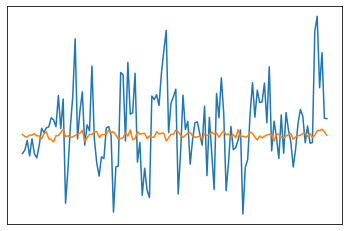

Training model mmd_conv1d_500_64, epoch=9
Epoch: 9, Test set losses: [0.6910215  0.01670147 0.67432002], time elapsed for current epoch 36.09390711784363
mmd_conv1d_500_64


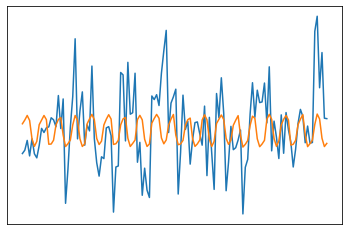

Training model vanilla_conv1d_500_64, epoch=9
Epoch: 9, Test set losses: [0.67401399 7.36168329 0.67397718], time elapsed for current epoch 29.474205255508423
vanilla_conv1d_500_64


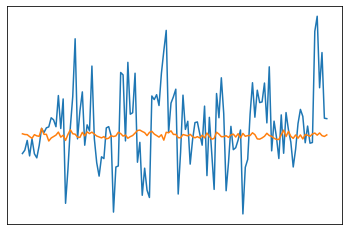

Training model mmd_conv1d_500_64, epoch=10
Epoch: 10, Test set losses: [0.69081055 0.0166599  0.67415065], time elapsed for current epoch 35.33211851119995
mmd_conv1d_500_64


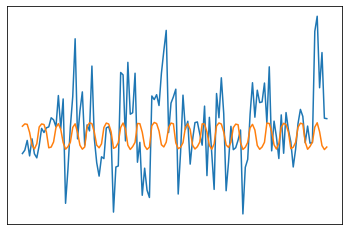

Training model vanilla_conv1d_500_64, epoch=10
Epoch: 10, Test set losses: [0.67421095 7.3381509  0.67417425], time elapsed for current epoch 30.220723628997803
vanilla_conv1d_500_64


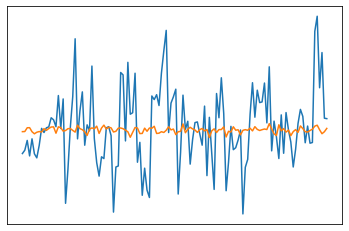

Training model mmd_conv1d_500_64, epoch=11
Epoch: 11, Test set losses: [0.69081721 0.01668382 0.6741334 ], time elapsed for current epoch 35.333585262298584
mmd_conv1d_500_64


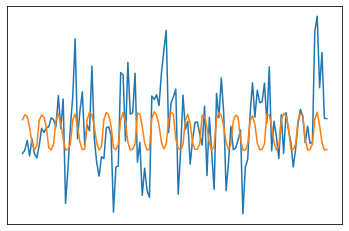

Training model vanilla_conv1d_500_64, epoch=11
Epoch: 11, Test set losses: [0.67401193 7.10967636 0.67397638], time elapsed for current epoch 29.403424978256226
vanilla_conv1d_500_64


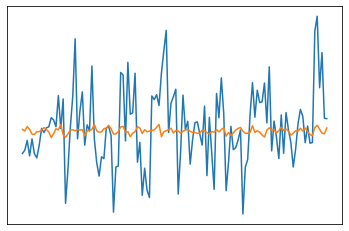

Training model mmd_conv1d_500_64, epoch=12
Epoch: 12, Test set losses: [0.69070377 0.01670569 0.67399809], time elapsed for current epoch 35.994205951690674
mmd_conv1d_500_64


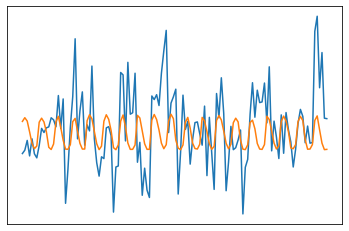

Training model vanilla_conv1d_500_64, epoch=12
Epoch: 12, Test set losses: [0.67420904 7.26417854 0.67417271], time elapsed for current epoch 29.55507802963257
vanilla_conv1d_500_64


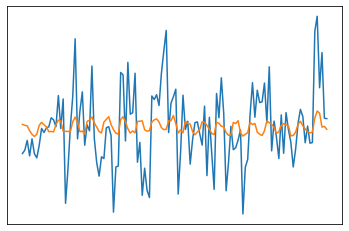

Training model mmd_conv1d_500_64, epoch=13
Epoch: 13, Test set losses: [0.6907623  0.01662436 0.67413794], time elapsed for current epoch 35.429362058639526
mmd_conv1d_500_64


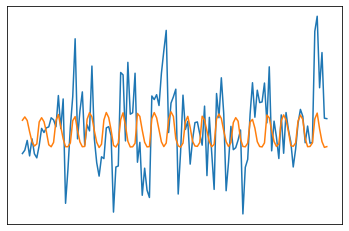

Training model vanilla_conv1d_500_64, epoch=13
Epoch: 13, Test set losses: [0.67402219 7.42265206 0.67398508], time elapsed for current epoch 29.40548539161682
vanilla_conv1d_500_64


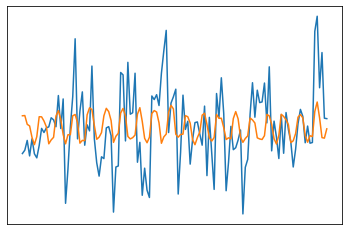

Training model mmd_conv1d_500_64, epoch=14
Epoch: 14, Test set losses: [0.69068789 0.016701   0.67398688], time elapsed for current epoch 36.069854736328125
mmd_conv1d_500_64


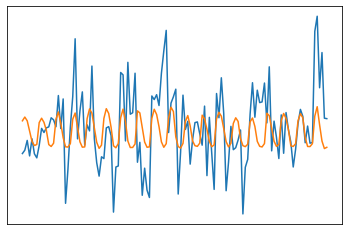

Training model vanilla_conv1d_500_64, epoch=14
Epoch: 14, Test set losses: [0.67394671 7.79885356 0.67390771], time elapsed for current epoch 29.457500457763672
vanilla_conv1d_500_64


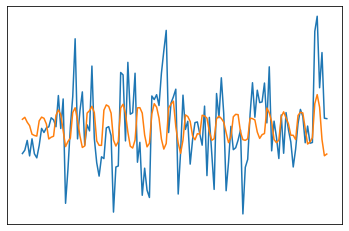

Training model mmd_conv1d_500_64, epoch=15
Epoch: 15, Test set losses: [0.69045939 0.01670047 0.67375892], time elapsed for current epoch 35.433626890182495
mmd_conv1d_500_64


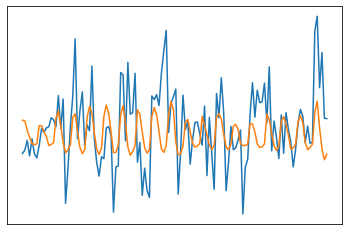

Training model vanilla_conv1d_500_64, epoch=15
Epoch: 15, Test set losses: [0.67406269 8.31233104 0.67402113], time elapsed for current epoch 29.416003704071045
vanilla_conv1d_500_64


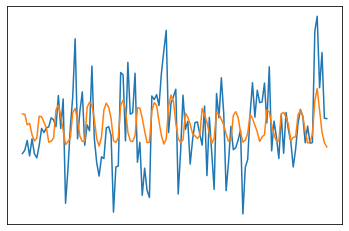

Training model mmd_conv1d_500_64, epoch=16
Epoch: 16, Test set losses: [0.69082629 0.0168045  0.67402179], time elapsed for current epoch 36.11398458480835
mmd_conv1d_500_64


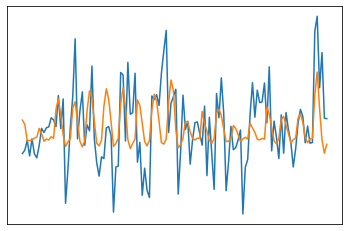

Training model vanilla_conv1d_500_64, epoch=16
Epoch: 16, Test set losses: [0.67392654 8.42219316 0.67388442], time elapsed for current epoch 29.506864547729492
vanilla_conv1d_500_64


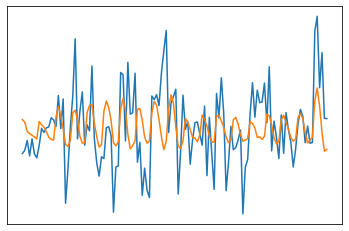

Training model mmd_conv1d_500_64, epoch=17
Epoch: 17, Test set losses: [0.69066597 0.01667291 0.67399305], time elapsed for current epoch 35.365859270095825
mmd_conv1d_500_64


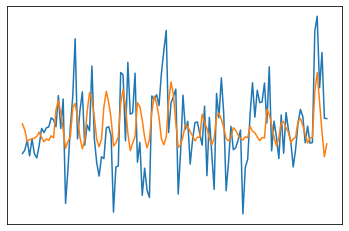

Training model vanilla_conv1d_500_64, epoch=17
Epoch: 17, Test set losses: [0.67406062 8.69166909 0.67401716], time elapsed for current epoch 29.433903455734253
vanilla_conv1d_500_64


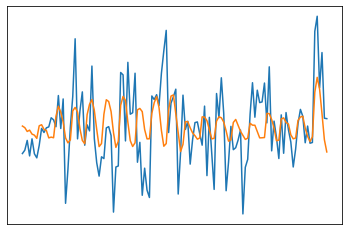

Training model mmd_conv1d_500_64, epoch=18
Epoch: 18, Test set losses: [0.69062652 0.01668698 0.67393954], time elapsed for current epoch 36.10251474380493
mmd_conv1d_500_64


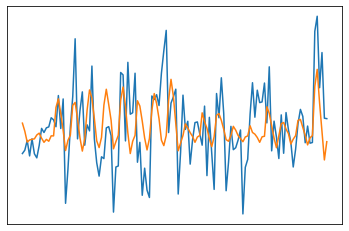

Training model vanilla_conv1d_500_64, epoch=18
Epoch: 18, Test set losses: [0.67405597 8.76950709 0.67401213], time elapsed for current epoch 29.50364923477173
vanilla_conv1d_500_64


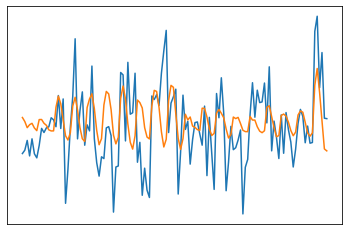

Training model mmd_conv1d_500_64, epoch=19
Epoch: 19, Test set losses: [0.69071077 0.01668855 0.67402221], time elapsed for current epoch 35.40346050262451
mmd_conv1d_500_64


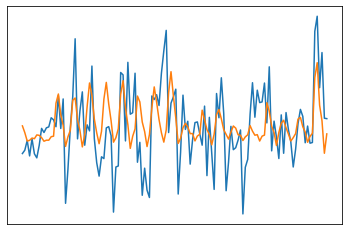

Training model vanilla_conv1d_500_64, epoch=19
Epoch: 19, Test set losses: [0.67411665 9.04982853 0.6740714 ], time elapsed for current epoch 29.414793968200684
vanilla_conv1d_500_64


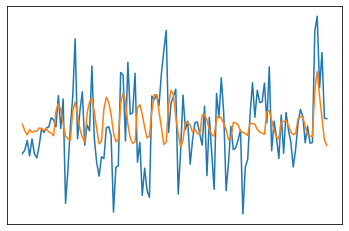

Training model mmd_conv1d_500_64, epoch=20
Epoch: 20, Test set losses: [0.69053234 0.01658452 0.67394782], time elapsed for current epoch 36.120253562927246
mmd_conv1d_500_64


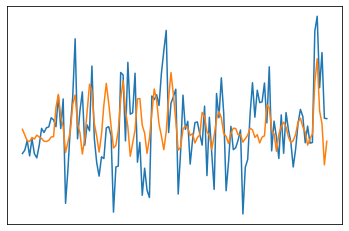

Training model vanilla_conv1d_500_64, epoch=20
Epoch: 20, Test set losses: [0.67402872 9.2300637  0.67398257], time elapsed for current epoch 29.40269374847412
vanilla_conv1d_500_64


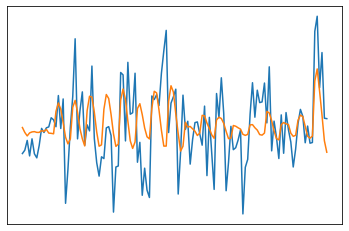

Training model mmd_conv1d_500_64, epoch=21
Epoch: 21, Test set losses: [0.69046965 0.01670571 0.67376394], time elapsed for current epoch 35.421273708343506
mmd_conv1d_500_64


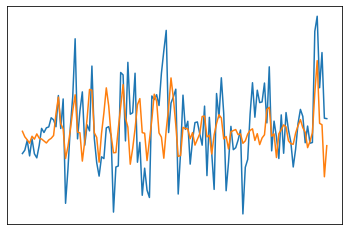

Training model vanilla_conv1d_500_64, epoch=21
Epoch: 21, Test set losses: [0.67404243 9.5236321  0.67399481], time elapsed for current epoch 29.4444682598114
vanilla_conv1d_500_64


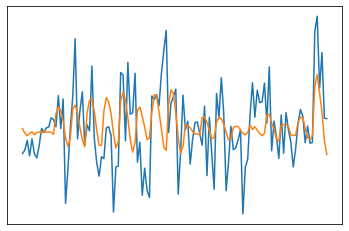

Training model mmd_conv1d_500_64, epoch=22
Epoch: 22, Test set losses: [0.69055324 0.01665071 0.67390254], time elapsed for current epoch 35.78433275222778
mmd_conv1d_500_64


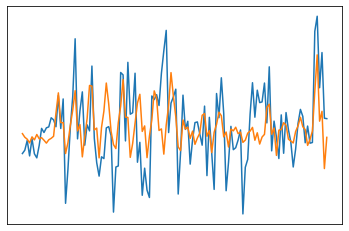

Training model vanilla_conv1d_500_64, epoch=22
Epoch: 22, Test set losses: [0.67390193 9.8763708  0.67385255], time elapsed for current epoch 29.72595715522766
vanilla_conv1d_500_64


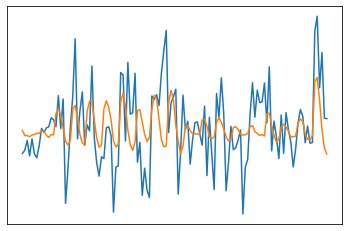

Training model mmd_conv1d_500_64, epoch=23
Epoch: 23, Test set losses: [0.6906092  0.01672436 0.67388484], time elapsed for current epoch 35.452428102493286
mmd_conv1d_500_64


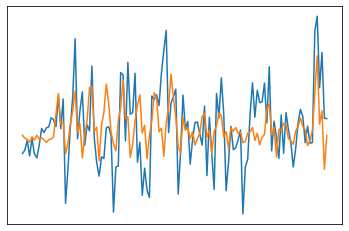

Training model vanilla_conv1d_500_64, epoch=23
Epoch: 23, Test set losses: [ 0.6740182  10.26356575  0.67396688], time elapsed for current epoch 29.425766468048096
vanilla_conv1d_500_64


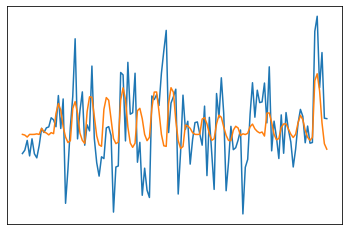

Training model mmd_conv1d_500_64, epoch=24
Epoch: 24, Test set losses: [0.6903637 0.0166562 0.6737075], time elapsed for current epoch 35.35132336616516
mmd_conv1d_500_64


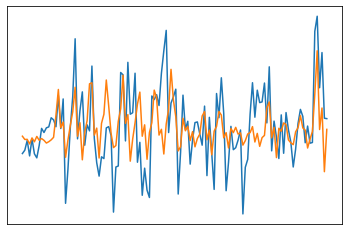

Training model vanilla_conv1d_500_64, epoch=24
Epoch: 24, Test set losses: [ 0.67396459 10.4686247   0.67391224], time elapsed for current epoch 29.601515531539917
vanilla_conv1d_500_64


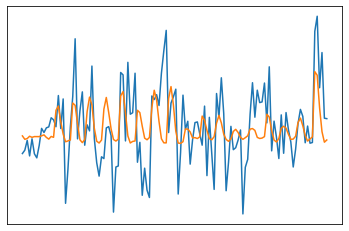

Training model mmd_conv1d_500_64, epoch=25
Epoch: 25, Test set losses: [0.6905796 0.0166781 0.6739015], time elapsed for current epoch 35.91614747047424
mmd_conv1d_500_64


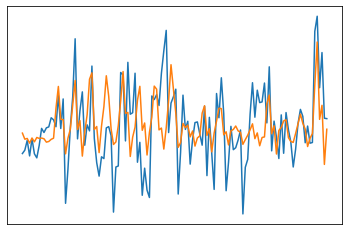

Training model vanilla_conv1d_500_64, epoch=25
Epoch: 25, Test set losses: [ 0.67400138 10.79678954  0.67394739], time elapsed for current epoch 29.47831416130066
vanilla_conv1d_500_64


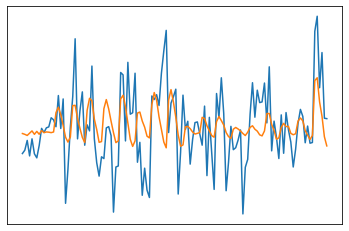

Training model mmd_conv1d_500_64, epoch=26
Epoch: 26, Test set losses: [0.69030538 0.01667119 0.67363418], time elapsed for current epoch 35.361210107803345
mmd_conv1d_500_64


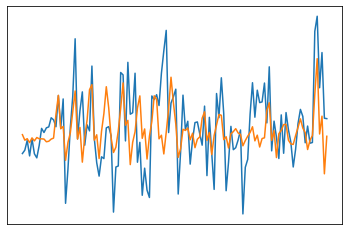

Training model vanilla_conv1d_500_64, epoch=26
Epoch: 26, Test set losses: [ 0.67393685 11.02437809  0.67388173], time elapsed for current epoch 29.592264890670776
vanilla_conv1d_500_64


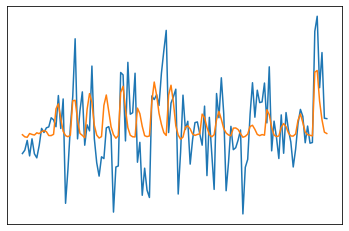

Training model mmd_conv1d_500_64, epoch=27
Epoch: 27, Test set losses: [0.69025885 0.01673995 0.67351889], time elapsed for current epoch 35.914705991744995
mmd_conv1d_500_64


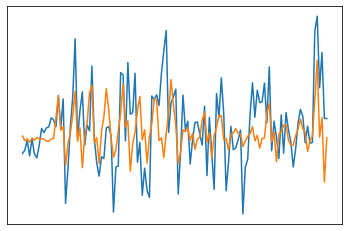

Training model vanilla_conv1d_500_64, epoch=27
Epoch: 27, Test set losses: [ 0.67366765 11.28537856  0.67361122], time elapsed for current epoch 29.485594272613525
vanilla_conv1d_500_64


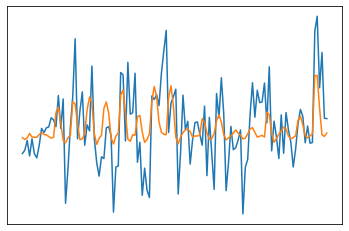

Training model mmd_conv1d_500_64, epoch=28
Epoch: 28, Test set losses: [0.69047617 0.01667438 0.67380178], time elapsed for current epoch 35.372387409210205
mmd_conv1d_500_64


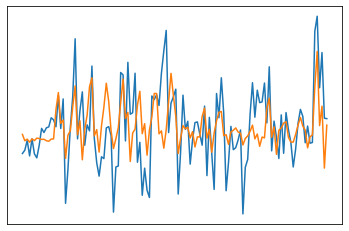

Training model vanilla_conv1d_500_64, epoch=28
Epoch: 28, Test set losses: [ 0.67400889 12.15615103  0.67394811], time elapsed for current epoch 29.437662839889526
vanilla_conv1d_500_64


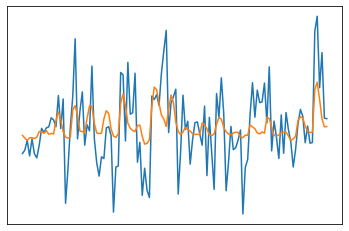

Training model mmd_conv1d_500_64, epoch=29
Epoch: 29, Test set losses: [0.69041798 0.01665117 0.67376682], time elapsed for current epoch 36.04408860206604
mmd_conv1d_500_64


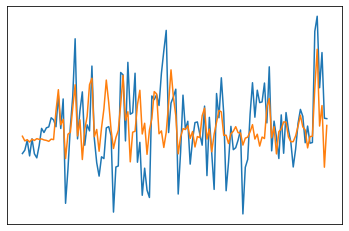

Training model vanilla_conv1d_500_64, epoch=29
Epoch: 29, Test set losses: [0.67391973 8.50704421 0.6738772 ], time elapsed for current epoch 29.485700607299805
vanilla_conv1d_500_64


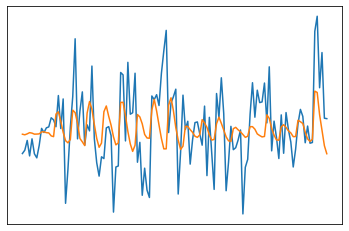

Training model mmd_conv1d_500_64, epoch=30
Epoch: 30, Test set losses: [0.69063806 0.01673393 0.67390413], time elapsed for current epoch 35.43676543235779
mmd_conv1d_500_64


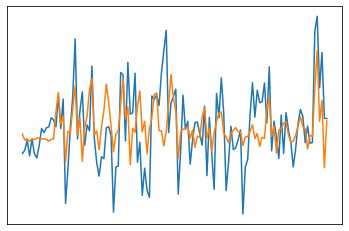

Training model vanilla_conv1d_500_64, epoch=30
Epoch: 30, Test set losses: [ 0.67389132 10.33497673  0.67383965], time elapsed for current epoch 29.423429250717163
vanilla_conv1d_500_64


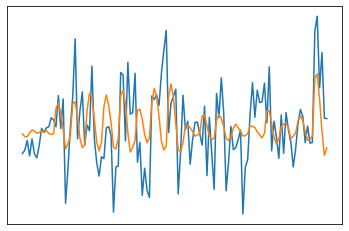

Training model mmd_conv1d_500_64, epoch=31
Epoch: 31, Test set losses: [0.69064127 0.01667585 0.67396542], time elapsed for current epoch 35.35078167915344
mmd_conv1d_500_64


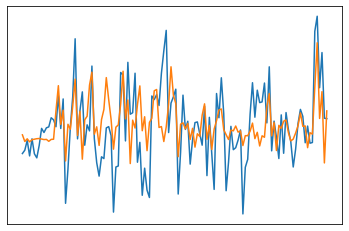

Training model vanilla_conv1d_500_64, epoch=31
Epoch: 31, Test set losses: [ 0.67392401 12.48672846  0.67386157], time elapsed for current epoch 29.965651750564575
vanilla_conv1d_500_64


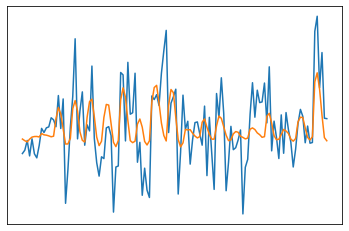

Training model mmd_conv1d_500_64, epoch=32
Epoch: 32, Test set losses: [0.69038416 0.01668166 0.6737025 ], time elapsed for current epoch 35.53883767127991
mmd_conv1d_500_64


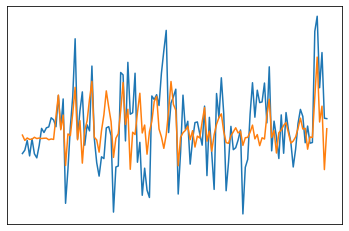

Training model vanilla_conv1d_500_64, epoch=32
Epoch: 32, Test set losses: [ 0.67386027 14.52819257  0.67378762], time elapsed for current epoch 29.495166301727295
vanilla_conv1d_500_64


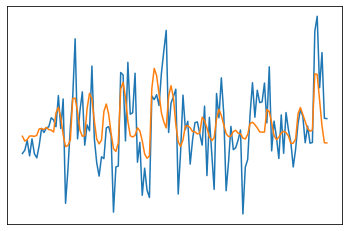

Training model mmd_conv1d_500_64, epoch=33
Epoch: 33, Test set losses: [0.69028937 0.01673289 0.67355648], time elapsed for current epoch 35.35571837425232
mmd_conv1d_500_64


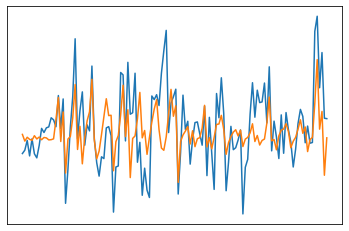

Training model vanilla_conv1d_500_64, epoch=33
Epoch: 33, Test set losses: [ 0.67373781 15.57330704  0.67365995], time elapsed for current epoch 29.431135177612305
vanilla_conv1d_500_64


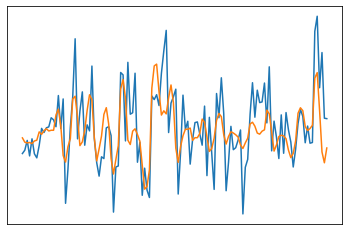

Training model mmd_conv1d_500_64, epoch=34
Epoch: 34, Test set losses: [0.69050847 0.016774   0.67373447], time elapsed for current epoch 35.79956817626953
mmd_conv1d_500_64


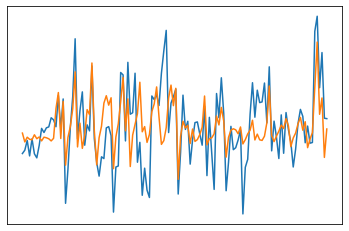

Training model vanilla_conv1d_500_64, epoch=34
Epoch: 34, Test set losses: [ 0.67379844 16.60103379  0.67371544], time elapsed for current epoch 29.739079475402832
vanilla_conv1d_500_64


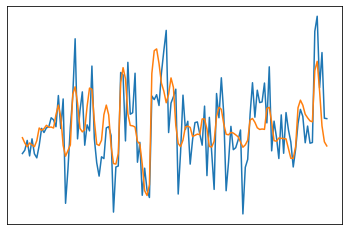

Training model mmd_conv1d_500_64, epoch=35
Epoch: 35, Test set losses: [0.69036065 0.01671902 0.67364163], time elapsed for current epoch 35.430821895599365
mmd_conv1d_500_64


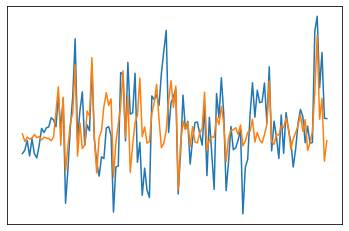

Training model vanilla_conv1d_500_64, epoch=35
Epoch: 35, Test set losses: [ 0.67386939 17.71655835  0.67378081], time elapsed for current epoch 29.43990182876587
vanilla_conv1d_500_64


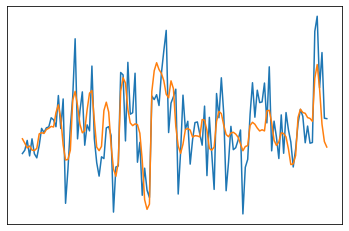

Training model mmd_conv1d_500_64, epoch=36
Epoch: 36, Test set losses: [0.69036505 0.01678612 0.67357894], time elapsed for current epoch 35.35486817359924
mmd_conv1d_500_64


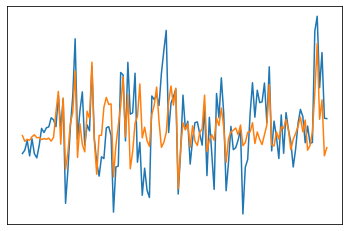

Training model vanilla_conv1d_500_64, epoch=36
Epoch: 36, Test set losses: [ 0.67357048 17.53617456  0.6734828 ], time elapsed for current epoch 30.162333488464355
vanilla_conv1d_500_64


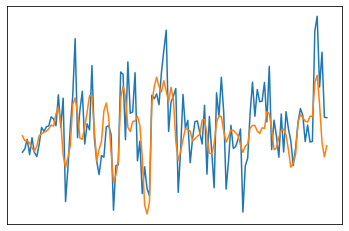

Training model mmd_conv1d_500_64, epoch=37
Epoch: 37, Test set losses: [0.69051403 0.01667244 0.6738416 ], time elapsed for current epoch 35.458580493927
mmd_conv1d_500_64


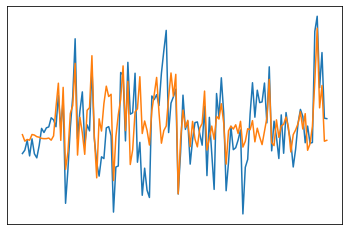

Training model vanilla_conv1d_500_64, epoch=37
Epoch: 37, Test set losses: [ 0.67374912 17.05618276  0.67366384], time elapsed for current epoch 29.435415983200073
vanilla_conv1d_500_64


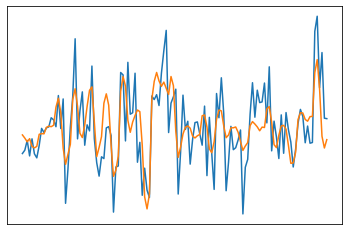

Training model mmd_conv1d_500_64, epoch=38
Epoch: 38, Test set losses: [0.69030645 0.0166748  0.67363165], time elapsed for current epoch 35.38399648666382
mmd_conv1d_500_64


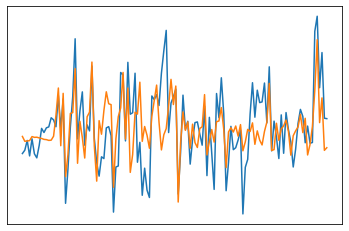

Training model vanilla_conv1d_500_64, epoch=38
Epoch: 38, Test set losses: [ 0.67384436 16.8528809   0.6737601 ], time elapsed for current epoch 29.465629816055298
vanilla_conv1d_500_64


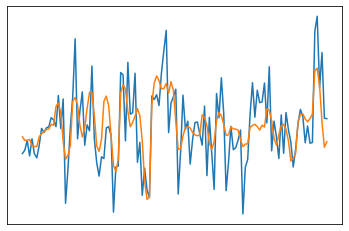

Training model mmd_conv1d_500_64, epoch=39
Epoch: 39, Test set losses: [0.69030503 0.01681448 0.67349055], time elapsed for current epoch 36.10644292831421
mmd_conv1d_500_64


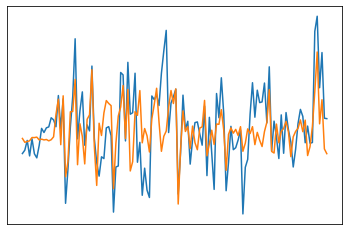

Training model vanilla_conv1d_500_64, epoch=39
Epoch: 39, Test set losses: [ 0.67377801 16.60001204  0.67369501], time elapsed for current epoch 29.511014699935913
vanilla_conv1d_500_64


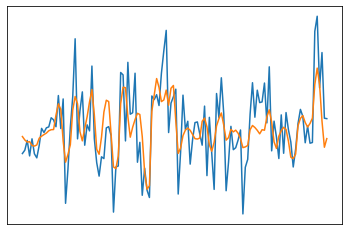

Training model mmd_conv1d_500_64, epoch=40
Epoch: 40, Test set losses: [0.69020656 0.01669505 0.67351151], time elapsed for current epoch 35.38140082359314
mmd_conv1d_500_64


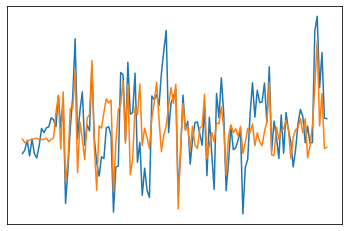

Training model vanilla_conv1d_500_64, epoch=40
Epoch: 40, Test set losses: [ 0.67376389 16.50575442  0.67368136], time elapsed for current epoch 29.431779861450195
vanilla_conv1d_500_64


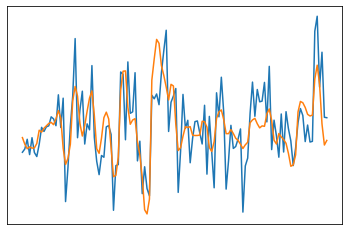

Training model mmd_conv1d_500_64, epoch=41
Epoch: 41, Test set losses: [0.69021498 0.01669488 0.67352011], time elapsed for current epoch 36.14385962486267
mmd_conv1d_500_64


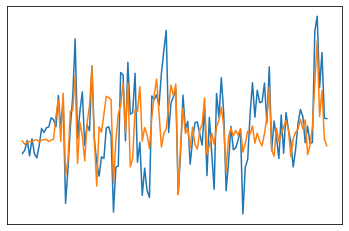

Training model vanilla_conv1d_500_64, epoch=41
Epoch: 41, Test set losses: [ 0.67381821 16.52050283  0.67373561], time elapsed for current epoch 29.498462915420532
vanilla_conv1d_500_64


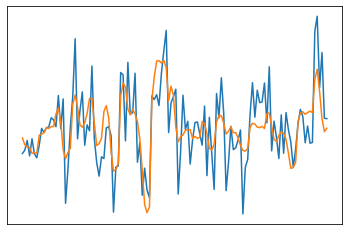

Training model mmd_conv1d_500_64, epoch=42
Epoch: 42, Test set losses: [0.69042508 0.01666289 0.67376219], time elapsed for current epoch 35.36745595932007
mmd_conv1d_500_64


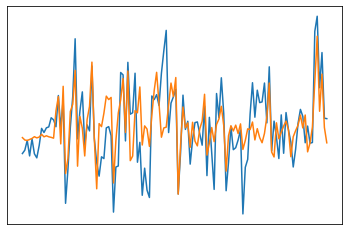

Training model vanilla_conv1d_500_64, epoch=42
Epoch: 42, Test set losses: [ 0.67371997 16.6382263   0.67363678], time elapsed for current epoch 29.421801567077637
vanilla_conv1d_500_64


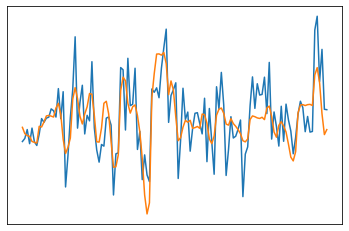

Training model mmd_conv1d_500_64, epoch=43
Epoch: 43, Test set losses: [0.69030678 0.01665108 0.6736557 ], time elapsed for current epoch 35.89726519584656
mmd_conv1d_500_64


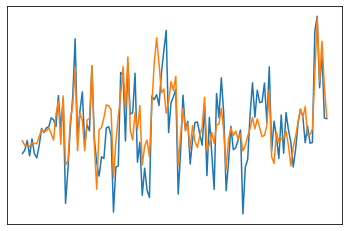

Training model vanilla_conv1d_500_64, epoch=43
Epoch: 43, Test set losses: [ 0.67375592 16.37580294  0.67367404], time elapsed for current epoch 29.630285024642944
vanilla_conv1d_500_64


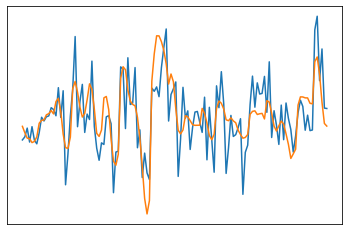

Training model mmd_conv1d_500_64, epoch=44
Epoch: 44, Test set losses: [0.69009774 0.01673728 0.67336047], time elapsed for current epoch 35.45465874671936
mmd_conv1d_500_64


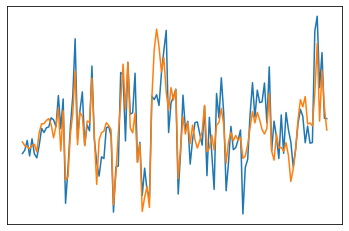

Training model vanilla_conv1d_500_64, epoch=44
Epoch: 44, Test set losses: [ 0.67378564 15.8332457   0.67370648], time elapsed for current epoch 29.433820486068726
vanilla_conv1d_500_64


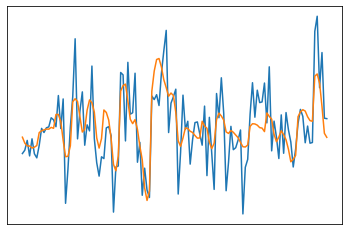

Training model mmd_conv1d_500_64, epoch=45
Epoch: 45, Test set losses: [0.69025395 0.01675495 0.673499  ], time elapsed for current epoch 35.37690734863281
mmd_conv1d_500_64


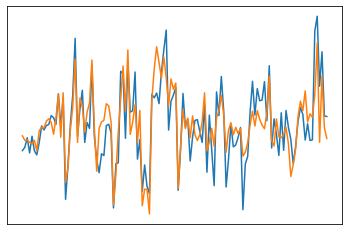

Training model vanilla_conv1d_500_64, epoch=45
Epoch: 45, Test set losses: [ 0.67381444 15.50657018  0.67373691], time elapsed for current epoch 30.182690143585205
vanilla_conv1d_500_64


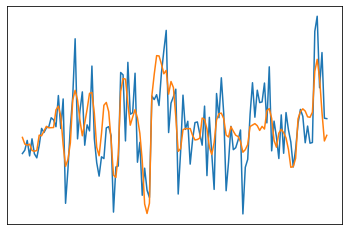

Training model mmd_conv1d_500_64, epoch=46
Epoch: 46, Test set losses: [0.6902064  0.01675776 0.67344863], time elapsed for current epoch 35.45116567611694
mmd_conv1d_500_64


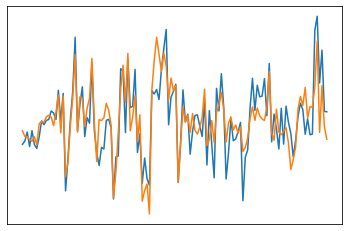

Training model vanilla_conv1d_500_64, epoch=46
Epoch: 46, Test set losses: [ 0.67379929 15.25040923  0.67372303], time elapsed for current epoch 29.42004704475403
vanilla_conv1d_500_64


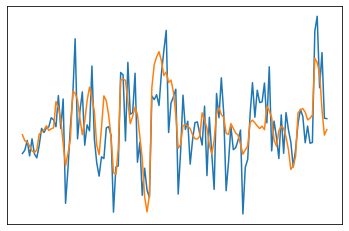

Training model mmd_conv1d_500_64, epoch=47
Epoch: 47, Test set losses: [0.69017516 0.01671735 0.6734578 ], time elapsed for current epoch 35.37196350097656
mmd_conv1d_500_64


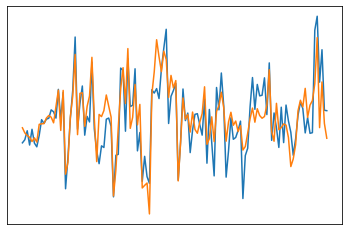

Training model vanilla_conv1d_500_64, epoch=47
Epoch: 47, Test set losses: [ 0.67376443 15.08805503  0.673689  ], time elapsed for current epoch 30.16471529006958
vanilla_conv1d_500_64


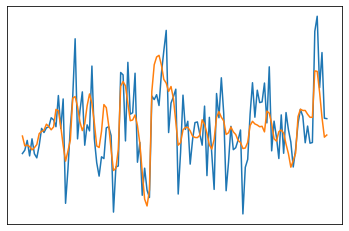

Training model mmd_conv1d_500_64, epoch=48
Epoch: 48, Test set losses: [0.69018043 0.0167727  0.67340773], time elapsed for current epoch 35.45155572891235
mmd_conv1d_500_64


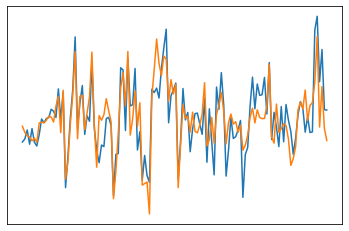

Training model vanilla_conv1d_500_64, epoch=48
Epoch: 48, Test set losses: [ 0.67379295 14.90470187  0.67371843], time elapsed for current epoch 29.39349603652954
vanilla_conv1d_500_64


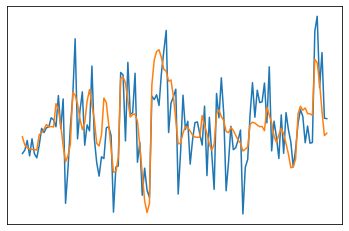

Training model mmd_conv1d_500_64, epoch=49
Epoch: 49, Test set losses: [0.69004156 0.01664017 0.67340139], time elapsed for current epoch 35.38324570655823
mmd_conv1d_500_64


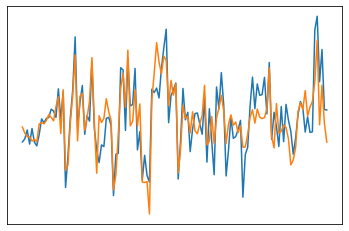

Training model vanilla_conv1d_500_64, epoch=49
Epoch: 49, Test set losses: [ 0.67376179 14.90227297  0.67368727], time elapsed for current epoch 29.474200963974
vanilla_conv1d_500_64


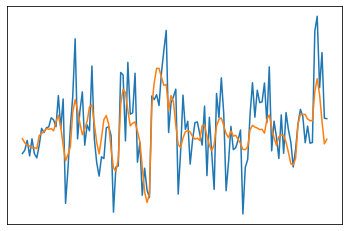

Training model mmd_conv1d_500_64, epoch=50
Epoch: 50, Test set losses: [0.69012612 0.01677075 0.67335538], time elapsed for current epoch 36.09808969497681
mmd_conv1d_500_64


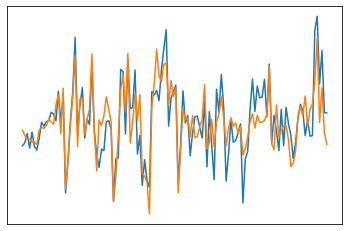

Training model vanilla_conv1d_500_64, epoch=50
Epoch: 50, Test set losses: [ 0.67366845 14.8151474   0.67359438], time elapsed for current epoch 29.501614332199097
vanilla_conv1d_500_64


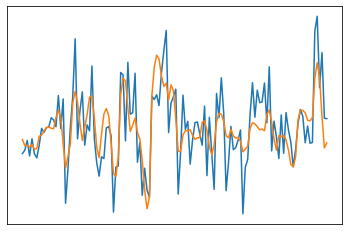

Training model mmd_conv1d_500_64, epoch=51
Epoch: 51, Test set losses: [0.68981504 0.0166575  0.67315754], time elapsed for current epoch 35.37877583503723
mmd_conv1d_500_64


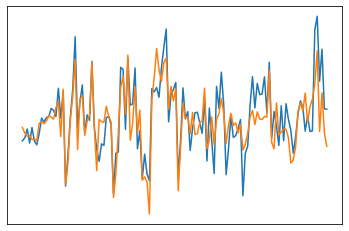

Training model vanilla_conv1d_500_64, epoch=51
Epoch: 51, Test set losses: [ 0.67379234 14.86995077  0.67371798], time elapsed for current epoch 29.44909977912903
vanilla_conv1d_500_64


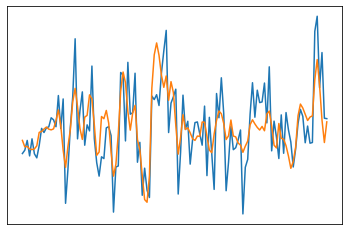

Training model mmd_conv1d_500_64, epoch=52
Epoch: 52, Test set losses: [0.6899926  0.01675589 0.67323669], time elapsed for current epoch 36.0822491645813
mmd_conv1d_500_64


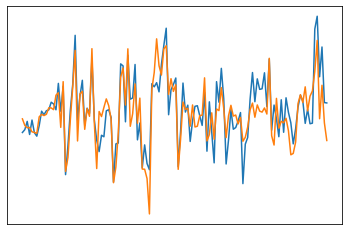

Training model vanilla_conv1d_500_64, epoch=52
Epoch: 52, Test set losses: [ 0.67380049 14.92104244  0.67372589], time elapsed for current epoch 29.45949101448059
vanilla_conv1d_500_64


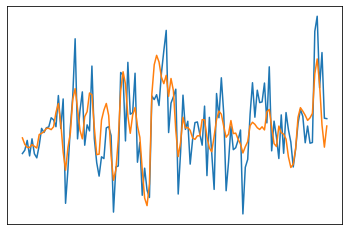

Training model mmd_conv1d_500_64, epoch=53
Epoch: 53, Test set losses: [0.68985883 0.01664734 0.67321149], time elapsed for current epoch 35.45214486122131
mmd_conv1d_500_64


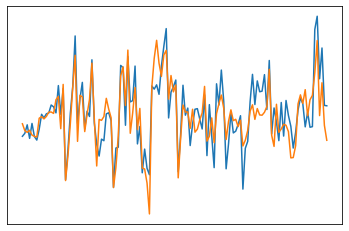

Training model vanilla_conv1d_500_64, epoch=53
Epoch: 53, Test set losses: [ 0.67385297 15.06426075  0.67377766], time elapsed for current epoch 29.426400184631348
vanilla_conv1d_500_64


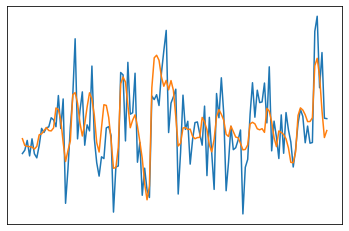

Training model mmd_conv1d_500_64, epoch=54
Epoch: 54, Test set losses: [0.68978591 0.01661437 0.67317154], time elapsed for current epoch 35.47834062576294
mmd_conv1d_500_64


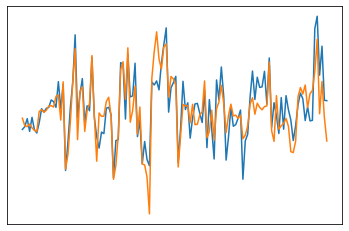

Training model vanilla_conv1d_500_64, epoch=54
Epoch: 54, Test set losses: [ 0.67378768 15.15696685  0.6737119 ], time elapsed for current epoch 30.058913230895996
vanilla_conv1d_500_64


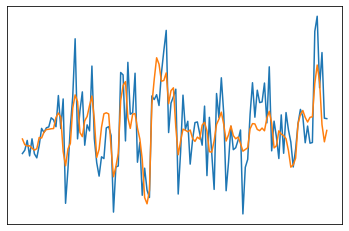

Training model mmd_conv1d_500_64, epoch=55
Epoch: 55, Test set losses: [0.68988882 0.01661802 0.67327081], time elapsed for current epoch 35.45355701446533
mmd_conv1d_500_64


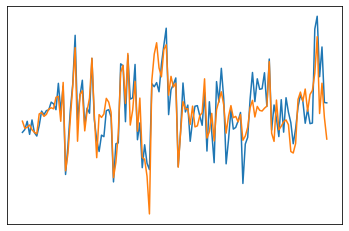

Training model vanilla_conv1d_500_64, epoch=55
Epoch: 55, Test set losses: [ 0.67371703 15.47130118  0.67363967], time elapsed for current epoch 29.41670846939087
vanilla_conv1d_500_64


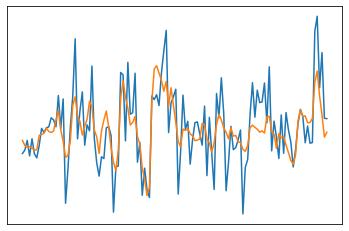

Training model mmd_conv1d_500_64, epoch=56
Epoch: 56, Test set losses: [0.68999469 0.01670129 0.6732934 ], time elapsed for current epoch 35.36849784851074
mmd_conv1d_500_64


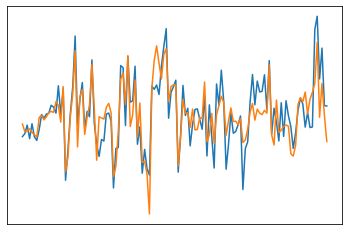

Training model vanilla_conv1d_500_64, epoch=56
Epoch: 56, Test set losses: [ 0.67370971 15.74181573  0.673631  ], time elapsed for current epoch 29.444775819778442
vanilla_conv1d_500_64


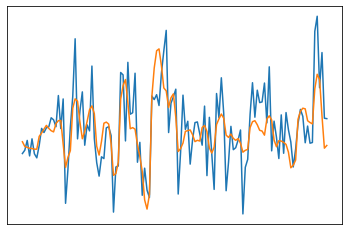

Training model mmd_conv1d_500_64, epoch=57
Epoch: 57, Test set losses: [0.69009103 0.01667982 0.67341121], time elapsed for current epoch 36.134700775146484
mmd_conv1d_500_64


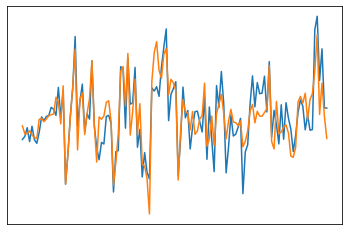

Training model vanilla_conv1d_500_64, epoch=57
Epoch: 57, Test set losses: [ 0.67382364 15.83507554  0.67374446], time elapsed for current epoch 29.493255376815796
vanilla_conv1d_500_64


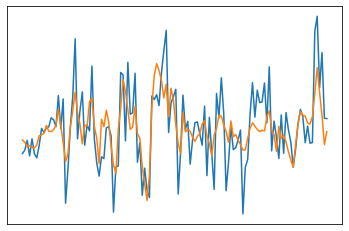

Training model mmd_conv1d_500_64, epoch=58
Epoch: 58, Test set losses: [0.69006084 0.01665917 0.67340168], time elapsed for current epoch 35.365134716033936
mmd_conv1d_500_64


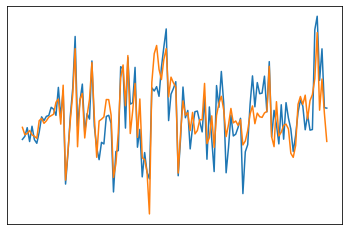

Training model vanilla_conv1d_500_64, epoch=58
Epoch: 58, Test set losses: [ 0.67372102 15.92485211  0.6736414 ], time elapsed for current epoch 29.44056463241577
vanilla_conv1d_500_64


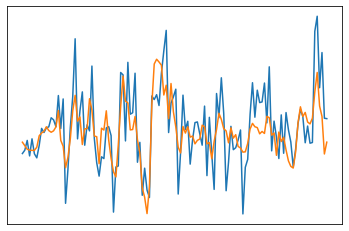

Training model mmd_conv1d_500_64, epoch=59
Epoch: 59, Test set losses: [0.68997282 0.0166878  0.67328502], time elapsed for current epoch 35.7308075428009
mmd_conv1d_500_64


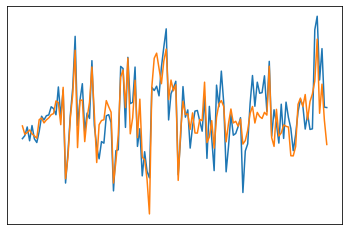

Training model vanilla_conv1d_500_64, epoch=59
Epoch: 59, Test set losses: [ 0.67368832 15.9980126   0.67360832], time elapsed for current epoch 29.803722143173218
vanilla_conv1d_500_64


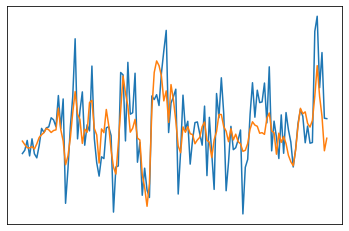

Training model mmd_conv1d_500_64, epoch=60
Epoch: 60, Test set losses: [0.68983191 0.01667949 0.67315242], time elapsed for current epoch 35.444302797317505
mmd_conv1d_500_64


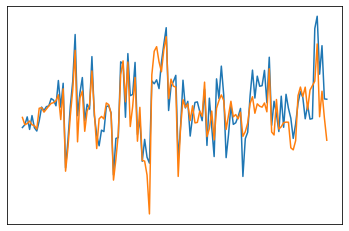

Training model vanilla_conv1d_500_64, epoch=60
Epoch: 60, Test set losses: [ 0.67382876 16.10686572  0.67374823], time elapsed for current epoch 29.44591522216797
vanilla_conv1d_500_64


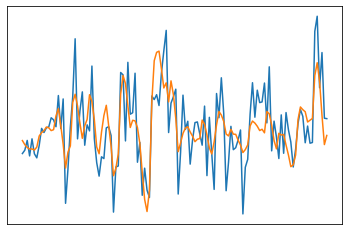

Training model mmd_conv1d_500_64, epoch=61
Epoch: 61, Test set losses: [0.69015918 0.01674489 0.67341429], time elapsed for current epoch 35.36333990097046
mmd_conv1d_500_64


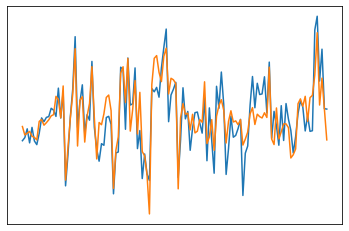

Training model vanilla_conv1d_500_64, epoch=61
Epoch: 61, Test set losses: [ 0.67390989 16.30325953  0.67382837], time elapsed for current epoch 30.165062427520752
vanilla_conv1d_500_64


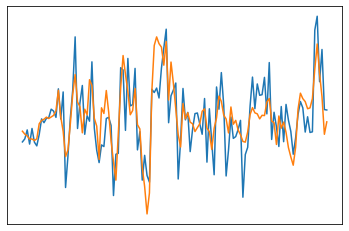

Training model mmd_conv1d_500_64, epoch=62
Epoch: 62, Test set losses: [0.69008544 0.01668345 0.67340199], time elapsed for current epoch 35.427602767944336
mmd_conv1d_500_64


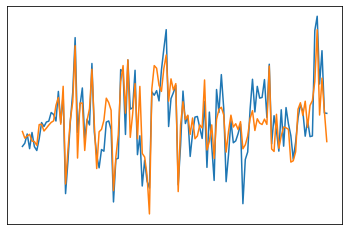

Training model vanilla_conv1d_500_64, epoch=62
Epoch: 62, Test set losses: [ 0.67383754 16.35343864  0.67375577], time elapsed for current epoch 29.424086332321167
vanilla_conv1d_500_64


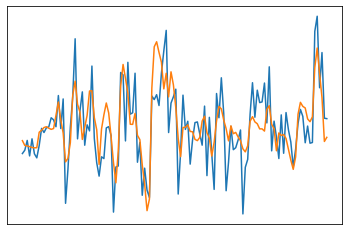

Training model mmd_conv1d_500_64, epoch=63


KeyboardInterrupt: 

In [11]:
epochs = 250
hidden_dims = [1024]
run_test = True

seq_dist = []
rand_dist = []

input_dim = np.prod(train_total_data.shape[1:])
#model_params = [('vanilla', 1e-3, 'mlp', 500), ('vanilla', 5e-3, 'mlp', 500), ('vanilla', 1e-4, 'mlp', 500), ('vanilla', 5e-4, 'mlp', 500)]
#model_params = [('mmd', 10, 'mlp', 500), ('mmd', 100, 'mlp', 500), ('mmd', 0.1, 'mlp', 500), ('mmd', 1e-2, 'mlp', 500)]
#model_params = [('vanilla', 1e-4, 'mlp', 500), ('vanilla', 5e-5, 'conv1d', 140)]

#model_params = [('vanilla', 1e-6, 'conv1d', 128, 128), ('mmd', 1000, 'conv1d', 128, 128)]
model_params = [('mmd', 1, 'conv1d', 500, 64), ('vanilla', 5e-6, 'conv1d', 500, 64)]
epoch_losses = np.zeros((len(model_params),epochs,3))
logdets = np.zeros((len(model_params),epochs))

models = [CVAE(latent_dim=la, 
              input_dim=input_dim, 
              hidden_dim=h,
              architecture=a, 
              loss_type=l,
              beta=b)
          for l, b, a, h, la in model_params]     

for m in models:
    total_parameters = 0
    for variable in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=m.scope):
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    print('{}: total_parameters={}'.format(m.scope, total_parameters))

for epoch in range(1, epochs + 1):
    for m_idx, m in enumerate(models):
        start_time = time.time()
        print("Training model {}, epoch={}".format(m.scope, epoch))
        for train_x in train_dataset.batches():
            train(m, train_x)

        losses = np.zeros(3)
        num_batches = 0

        if run_test:
            for test_x in test_dataset.batches():
                losses += get_loss(m, test_x)
                num_batches += 1

            avg_losses = losses / num_batches
            epoch_losses[m_idx,epoch - 1] = avg_losses

            #zs = m.latent_code(test_data[:100])
            #mean_cov = np.mean(np.square(np.cov(zs, rowvar=False) - np.identity(latent)))
            #print(mean_cov)
            #sign, logdet = np.linalg.slogdet(np.cov(zs, rowvar=False))
            #det = sign * np.exp(logdet)
            #logdets[m_idx,epoch-1] = det
            #print(det)

            end_time = time.time()

            print('Epoch: {}, Test set losses: {}, '
              'time elapsed for current epoch {}'.format(epoch,
                                                    avg_losses,
                                                    end_time - start_time))
            show_example_reconstruction(m)                    

s_d, r_d = get_distance_measurements(m)
seq_dist.append(s_d)
rand_dist.append(r_d)
print("Seq dist={}, rand dist={}".format(s_d, r_d))

            #display_reconstruction(idx_hidden+(4*idx_latent)+1, mmd_loss=mmd_loss, iaf=use_iaf)

In [ ]:
#plt.plot(list(range(-10,11)), seq_dist)
#plt.plot(list(range(-10,11)), rand_dist)
#plt.plot(list(range(-10,11)), np.array(rand_dist)/np.array(seq_dist))

<Figure size 432x288 with 0 Axes>

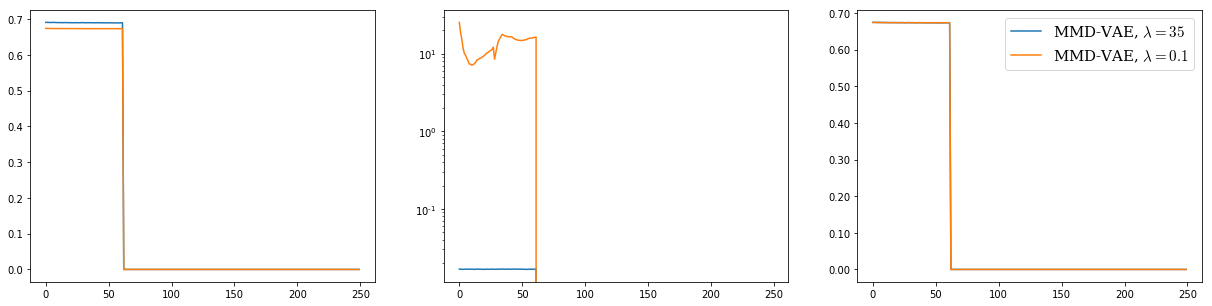

In [26]:
import matplotlib.font_manager
plt.clf()
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))

from matplotlib import rcParams
from matplotlib import rc
params = {'mathtext.fontset': 'cm',
          'font.family': 'serif'}

font = {'family' : 'serif',
        'weight': 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

labels = ['MMD-VAE, $\lambda=35$', 'MMD-VAE, $\lambda=0.1$',]

matplotlib.rcParams.update(params)
for m_idx, m in enumerate(models):
    for p in range(3):
        axes[p].plot(list(range(epochs)), epoch_losses[m_idx,:,p], label=labels[m_idx])

import matplotlib.ticker as mtick
axes[-1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.02f'))
axes[-2].set_yscale('log')
handles, labels = axes[-1].get_legend_handles_labels()
plt.legend()

plt.show()

In [24]:
def plot_pca(model, n_recordings=3, n_latents=500):
    max_idx = np.max(train_indices)

    
    test_dataset = GraphDataset.from_data(train_total_data).batch(BATCH_SIZE)
    all_latents = np.concatenate([model.latent_code(batch) for batch in test_dataset.batches()], axis=0) 
    pca = PCA(n_components=64)
    pca.fit(all_latents)
    plt.plot(list(range(64)), pca.explained_variance_ratio_)
    plt.show()
        
    plt.figure(figsize=(7,7))

    rand_idcs = np.random.choice(list(range(max_idx)), n_recordings)
    for r in rand_idcs:
        latents = all_latents[train_indices == r]
        idcs = np.random.choice(list(range(len(latents))), n_latents)
        if all_latents.shape[1] > 2:
            transformed = pca.transform(latents[idcs])
        else:
            transformed = latents[idcs]

        plt.scatter(transformed[:,0], transformed[:,1])
    plt.show()

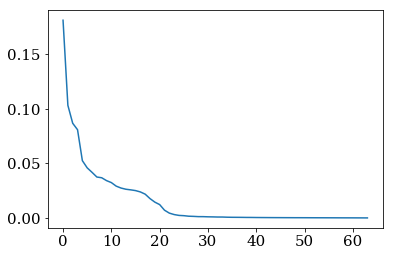

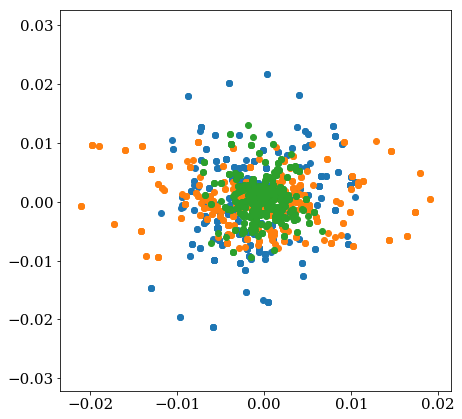

In [ ]:
plot_pca(models[0])
plot_pca(models[1])

In [ ]:
all_ratios = []
for m in models:
    ratios = []
    percents = []
    for i in range(100):
        train_total_data, test_data, train_indices, test_indices = load_data(i / 100)
        seq_dist, rand_dist = get_distance_measurements(m)
        print("{}: seq={}, rand={}, ratio={}".format(m.loss_type, seq_dist, rand_dist, rand_dist/seq_dist))
        ratios.append(rand_dist/seq_dist)
        #percent = calculate_distance(m)
        #percents.append(percent)
    all_ratios.append(ratios)


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.array(list(range(100)))/100, all_ratios[0], label='MMD-VAE')
plt.plot(np.array(list(range(100)))/100, all_ratios[1], label='$\\beta$-VAE')
plt.legend()
#plt.yscale('log')
plt.show()

In [ ]:
for m in models:
    show_example_reconstruction(m, 12)

In [ ]:
from scipy.stats import kde
def plot_densities(model):
    plt.clf()
    n_samples = 10000
    plt.figure(figsize=(7,7))
    p_z = np.random.multivariate_normal(np.zeros(2), np.identity(2), size=n_samples)
    #rand_idxs = np.random.choice(list(range(len(test_data))), size=10000)
    pq_z_x = np.concatenate([model.latent_code(batch) for batch in test_dataset.shuffle().batches()], axis=0)[:n_samples]
        
    #fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 6))    
        # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
        
    nbins=100
    x = p_z[:,0]
    y = p_z[:,1]
    k = kde.gaussian_kde((x,y))
    xi, yi = np.mgrid[-3:3:nbins*1j,-3:3:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues_r)
    #plt.set_title('$p(z)$', fontsize=20, y=1.08)
    
    plt.show()
    
    plt.figure(figsize=(7,7))

    #plt.ylim(-3,3)
    #plt.xlim(-3,3)
    print(pq_z_x.shape)
    evens = np.array(list(range(int(pq_z_x.shape[1] / 2)))) *2
    odds = evens + 1
    x = pq_z_x[:,evens].flatten()
    y = pq_z_x[:,odds].flatten()
    print(x.shape)
    k = kde.gaussian_kde((x,y))
    xi, yi = np.mgrid[-3:3:nbins*1j, -3:3:nbins*1j]
    #xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues_r)
    #axes[1].set_title('$q_{\\phi}(z|x)$', fontsize=20, y=1.08)
    #axes[1].set_xlim(-3,3)
    #axes[1].set_ylim(-3,3)

    plt.show()

In [ ]:
for m in models:
    plot_densities(m) 